# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Classes

In [2]:
class Regressor(object):
    """
    Creates objects to consolidate regression Scikit-Learn fitted model, with their training and testing data, performance evaluation.
    Handles grid search for model hyperparameter tuning.
    """
    
    def __init__(self, model, X_train, y_train, X_test, y_test, do_grid_search=False, grid_search_param=None, grid_search_cv=5, grid_search_scoring='neg_mean_squared_error'):
        """Instanciates object of class Regressor.

        Args:
            model (Scikit-Learn regression model): model to fit (fixed parameters can be defined)
            X_train (array): features array to train model
            y_train (vector): target vector to train model
            X_test (array): features array to train model
            y_test (vector): target vector to train model
            do_grid_search (bool, optional): indicates whether to perform hyperparameters grid search or return a fitted model with default hyperparameters. Defaults to False.
            grid_search_param (dict, optional): set of hyperparameters to test in grid search. Defaults to None.
            grid_search_cv (int, optional): number of cross-validation segments in training dataset. Defaults to 5.
            grid_search_scoring (str, optional): optimization metric during grid search. Defaults to 'neg_mean_squared_error'.
        """
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.do_grid_search = do_grid_search
        self.grid_search_param = grid_search_param
        self.grid_search_cv = grid_search_cv
        self.grid_search_scoring = grid_search_scoring
        self.fitted_model = self.trainModel()
        self.y_test_predicted = self.testModel()
        self.mse, self.mae, self.r2 = self.evaluateModel()
        
    def trainModel(self):
        """
        Fits model (either through a grid search or using default hyperparameters).

        Returns:
            Fitted model
        """
        if self.do_grid_search:
            grid_search = GridSearchCV(self.model, param_grid=self.grid_search_param, cv=self.grid_search_cv, scoring=self.grid_search_scoring)
            grid_search.fit(X=self.X_train, y=self.y_train)
            return grid_search.best_estimator_.fit(self.X_train, self.y_train)
        else:
            return self.model.fit(self.X_train, self.y_train)
    
    def testModel(self):
        """
        Applies fitted model to test set.

        Returns:
            Vector of predictions
        """
        return self.fitted_model.predict(self.X_test)
    
    def evaluateModel(self):
        """
        Evaluates fitted model performance.

        Returns:
            mse (float): Mean Squared Error
            mae (float): Mean Absolute Error
            r2 (float): R^2 Score
        """
        mse = mean_squared_error(y_true=self.y_test, y_pred=self.y_test_predicted)
        mae = mean_absolute_error(y_true=self.y_test, y_pred=self.y_test_predicted)
        r2 = r2_score(y_true=self.y_test, y_pred=self.y_test_predicted)
        return mse, mae, r2
    
    def __str__(self) -> str:
        """
        Full report on fitted model, hyperparameters and performance evaluation.

        Returns:
            summary (str): model fitting summary to be printed.
        """
        summary = f"\
Fitted model: {self.fitted_model.__str__()}\n\n\
Full model parameters: {self.fitted_model.get_params()}\n\n\
Mean Squared Error: {self.mse}\n\n\
Mean Absolute Error: {self.mae}\n\n\
R² Score: {self.r2}\n\n\
"
        return summary


# Functions

In [3]:
def plot_with_mean_and_spread(df, title=None, x_values=None):
    """
    Plots each row of the DataFrame with the mean and standard deviation.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the data to plot.
    title (str): Title to display
    """
    # Calculate column-wise mean and standard deviation
    mean = df.mean()
    std = df.std()
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    if x_values:
        # Plot each row
        for index, row in df.iterrows():
            plt.plot(x_values, row, color='gray', alpha=0.4)  # Plotting individual rows
        # Plot the mean line
        plt.plot(x_values, mean, color='blue', label='Mean', linewidth=2.5)
        # Plot the spread (3*standard deviation)
        plt.fill_between(x_values, mean - 3*std, mean + 3*std, color='red', alpha=0.3, label='±3 Std Dev')
    else:
        # Plot each row
        for index, row in df.iterrows():
            plt.plot(row, color='gray', alpha=0.4)  # Plotting individual rows
                # Plot the mean line
        plt.plot(mean, color='blue', label='Mean', linewidth=2.5)
        # Plot the spread (3*standard deviation)
        plt.fill_between(range(df.shape[1]), mean - 3*std, mean + 3*std, color='red', alpha=0.3, label='±3 Std Dev')
    
    # Add labels and legend
    plt.xlabel('Columns')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    
    # Show the plot
    plt.show()
    


def snv(arr):
    '''Applies Standard Normal Variate preprocessing to an array.'''
    
    # Calculate the mean and standard deviation for each row
    row_means = np.mean(arr, axis=1, keepdims=True)
    row_stds = np.std(arr, axis=1, keepdims=True)
    
    # Subtract the mean and divide by the standard deviation
    normalized_arr = (arr - row_means) / row_stds
    
    return normalized_arr



def savgol_derivative(arr, window_length=7, polyorder=2, deriv=1):
    """
    Apply the Savitzky-Golay filter to each row of the input array to compute derivatives.

    Parameters:
    arr (numpy.ndarray): Input 2D array.
    window_length (int): The length of the filter window (i.e., the number of coefficients).
    polyorder (int): The order of the polynomial used to fit the samples.
    deriv (int): The order of the derivative to compute (default is 1).

    Returns:
    numpy.ndarray: Array of the same shape as `arr` with row-wise derivatives.
    """
    
    # Initialize an empty array to store the derivatives
    derivatives = np.empty_like(arr)
    
    # Apply the Savitzky-Golay filter to each row
    for i in range(arr.shape[0]):
        derivatives[i] = savgol_filter(arr[i], window_length=window_length, polyorder=polyorder, deriv=deriv)
    
    return derivatives



def plot_actual_vs_prediction(Y_ref, Y_prd, title='Actual vs. Prediction'):
    """
    Plot the actual values versus predicted values with a y = x line.

    Parameters:
    - Y_ref: Array-like, actual values from the validation set.
    - Y_prd: Array-like, predicted values from the model.
    - title: String, the title of the plot.
    """
    plt.figure(figsize=(8, 8))
    
    # Scatter plot of actual vs predicted values
    plt.scatter(Y_ref, Y_prd, color='blue', label='Predicted vs. Actual')

    # Plot the y = x line
    min_val = min(Y_ref.min(), Y_prd.min())
    max_val = max(Y_ref.max(), Y_prd.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

    # Labeling the axes
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    
    # Adding a legend
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.show()


# Global Variables

In [4]:
PATH_TO_INPUT = '../Input/'
PATH_TO_OUTPUT = '../Input/'
PATH_TO_SCRIPT = '../Scripts/'

# Main Script

## Loading Data

In [5]:
# Training set
df_train = pd.read_csv(PATH_TO_INPUT + 'train_set.csv')
train_ID = df_train.ID 
train_Y = df_train.Yref.to_numpy()
train_X = df_train.iloc[:,2:].to_numpy()
print(f'Training dataset shape: Spectra = {train_X.shape}, Response = {train_Y.shape}\n')

# Testing set
df_test = pd.read_csv(PATH_TO_INPUT + 'test_set.csv')
test_ID = df_test.ID 
test_Y = df_test.Yref.to_numpy()
test_X = df_test.iloc[:,2:].to_numpy()
print(f'Testing dataset shape: Spectra = {test_X.shape}, Response = {test_Y.shape}\n')

# Validation set
df_validation_X = pd.read_csv(PATH_TO_INPUT + 'X_validation_HSI.csv')
df_validation_Y_ref = pd.read_csv(PATH_TO_INPUT + 'Y_validation.csv')
validation_ID = df_validation_X.SampleID.unique()
validation_X = df_validation_X.iloc[:,1:].groupby('SampleID').mean().to_numpy() # HyperSpectral Images averaged by SampleID
validation_Y_ref = df_validation_Y_ref.to_numpy().ravel()
print(f'Validation dataset shape: Spectra = {validation_X.shape}, Response = {validation_Y_ref.shape}\n')

# Wavelength range:
wl_range = list(range(1120, 1120+train_X.shape[1]*2, 2))

Training dataset shape: Spectra = (400, 653), Response = (400,)

Testing dataset shape: Spectra = (100, 653), Response = (100,)

Validation dataset shape: Spectra = (80, 653), Response = (80,)



## Data Pre-processing and Visualization

### Raw spectra plots

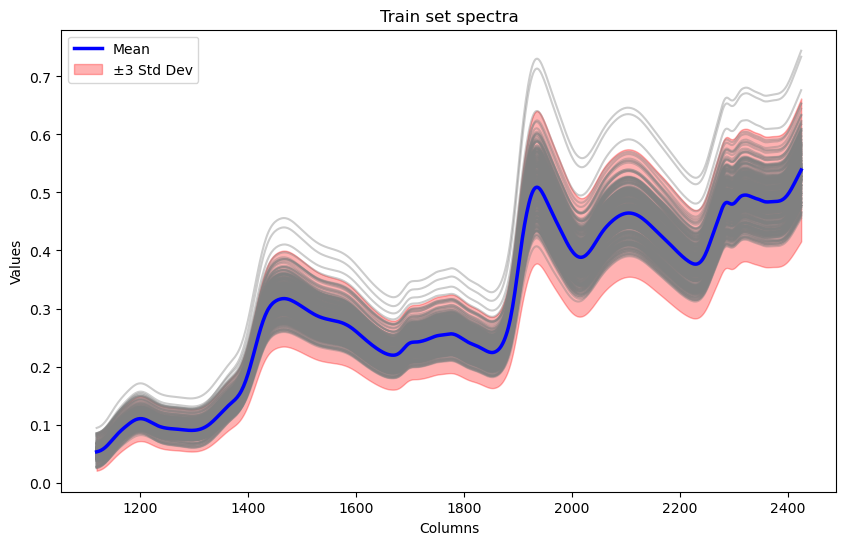

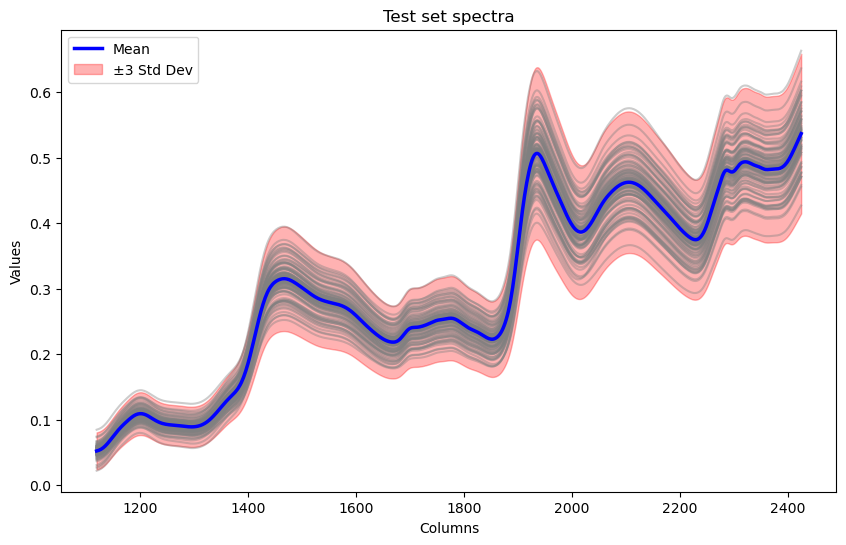

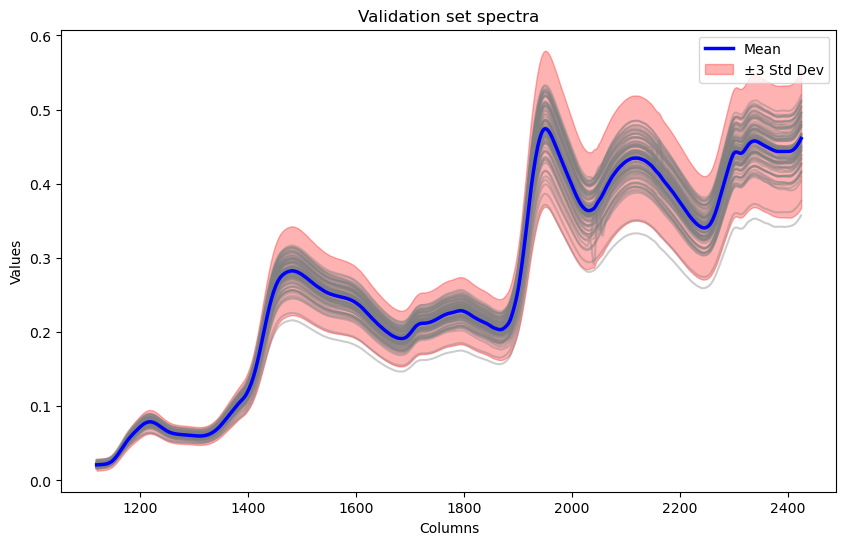

In [6]:
plot_with_mean_and_spread(df_train.iloc[:, 2:], title='Train set spectra', x_values=wl_range)
plot_with_mean_and_spread(df_test.iloc[:, 2:], title='Test set spectra', x_values=wl_range)
plot_with_mean_and_spread(pd.DataFrame(validation_X), title='Validation set spectra', x_values=wl_range)

### Spectra Pre-processing

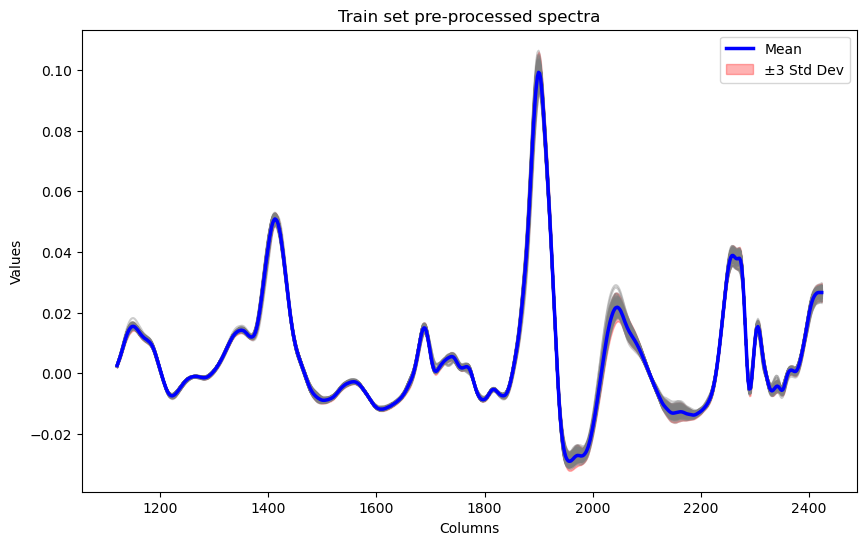

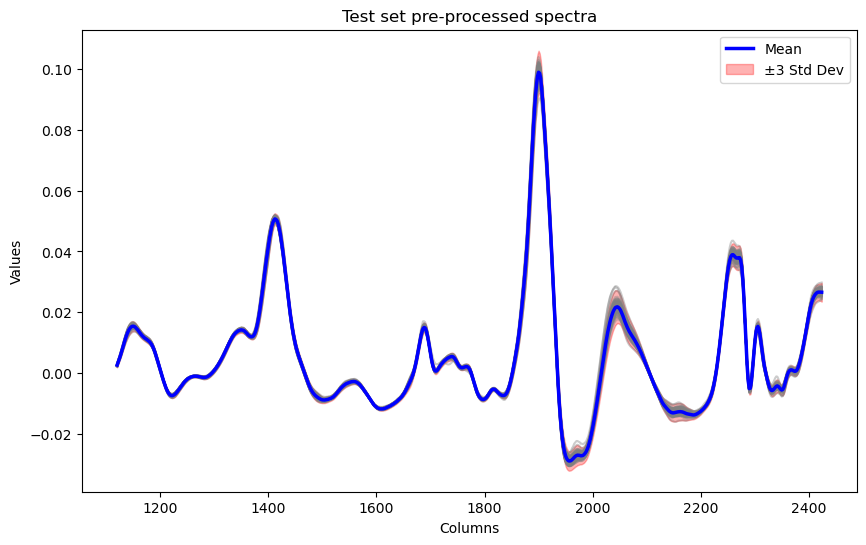

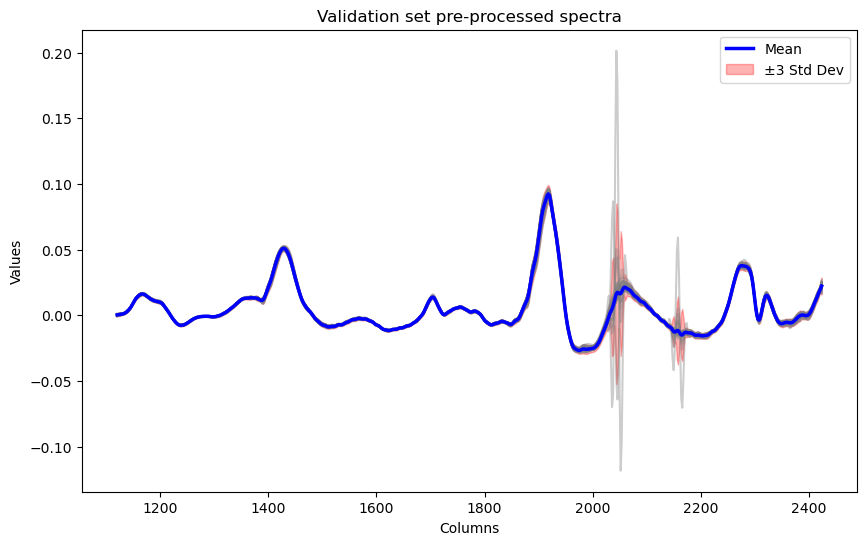

In [7]:
train_X_preprocess = savgol_derivative(snv(train_X), window_length=5, polyorder=2, deriv=1)
plot_with_mean_and_spread(pd.DataFrame(train_X_preprocess), title='Train set pre-processed spectra', x_values=wl_range)

test_X_preprocess = savgol_derivative(snv(test_X), window_length=5, polyorder=2, deriv=1)
plot_with_mean_and_spread(pd.DataFrame(test_X_preprocess), title='Test set pre-processed spectra', x_values=wl_range)

validation_X_preprocess = savgol_derivative(snv(validation_X), window_length=5, polyorder=2, deriv=1)
plot_with_mean_and_spread(pd.DataFrame(validation_X_preprocess), title='Validation set pre-processed spectra', x_values=wl_range)

In [8]:
# Additional preprocessing
scaler = StandardScaler()

train_X_preprocess_standard = scaler.fit_transform(train_X_preprocess)
test_X_preprocess_standard = scaler.transform(test_X_preprocess)
validation_X_preprocess_standard = scaler.transform(validation_X_preprocess)

## Modelling

### PLS regression model

Fitted model: PLSRegression(n_components=3)

Full model parameters: {'copy': True, 'max_iter': 500, 'n_components': 3, 'scale': True, 'tol': 1e-06}

Mean Squared Error: 0.26184132493428125

Mean Absolute Error: 0.41216913205961203

R² Score: 0.8991263050790629




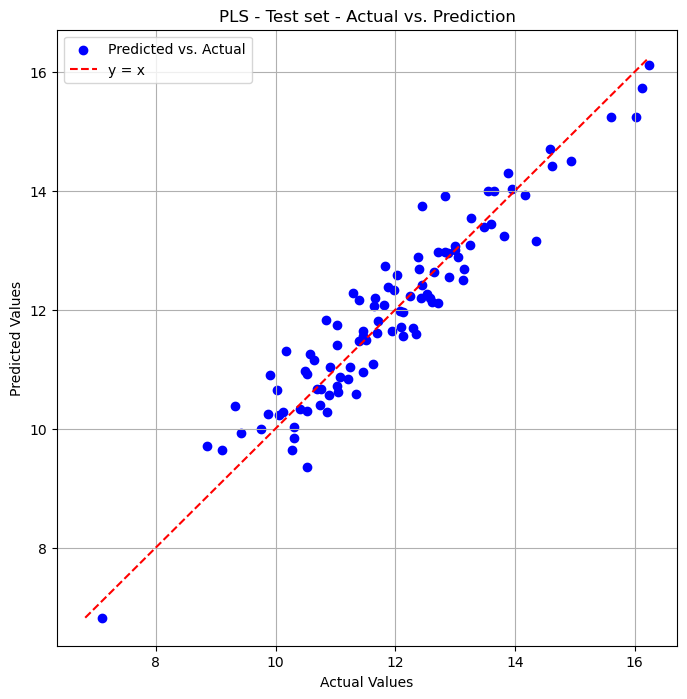

In [9]:
# Initialize the PLS model
model = PLSRegression()

# Define grid search parameters
do_grid_search = True
grid_search_param = [{
    'n_components': list(range(1, 4)),
    'scale': [True, False]}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
PLSqua_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess,
                             y_train=train_Y,
                             X_test=test_X_preprocess,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(PLSqua_regressor)

plot_actual_vs_prediction(PLSqua_regressor.y_test, PLSqua_regressor.y_test_predicted, title='PLS - Test set - Actual vs. Prediction')

### SVM regression model

Fitted model: SVR(C=1000, degree=6, kernel='poly')

Full model parameters: {'C': 1000, 'cache_size': 200, 'coef0': 0.0, 'degree': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Mean Squared Error: 0.06077781062825109

Mean Absolute Error: 0.19435923884410683

R² Score: 0.9765855052527883




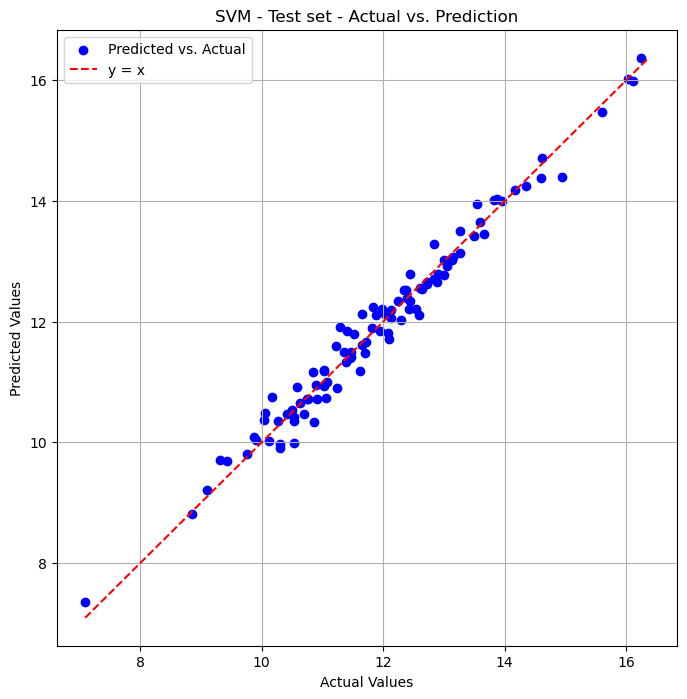

In [10]:
# Initialize the SVR model
model = SVR()

# Define grid search parameters
do_grid_search = True
grid_search_param = [{
    'C': [1, 10, 100, 1000],
    'epsilon': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [4, 5, 6],
    'gamma': ['auto', 'scale']}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
SVMach_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess,
                             y_train=train_Y,
                             X_test=test_X_preprocess,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(SVMach_regressor)

plot_actual_vs_prediction(SVMach_regressor.y_test, SVMach_regressor.y_test_predicted, title='SVM - Test set - Actual vs. Prediction')

### Random Forest regression model

Fitted model: RandomForestRegressor()

Full model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Mean Squared Error: 0.24989614638320387

Mean Absolute Error: 0.38732632841333314

R² Score: 0.903728154299158




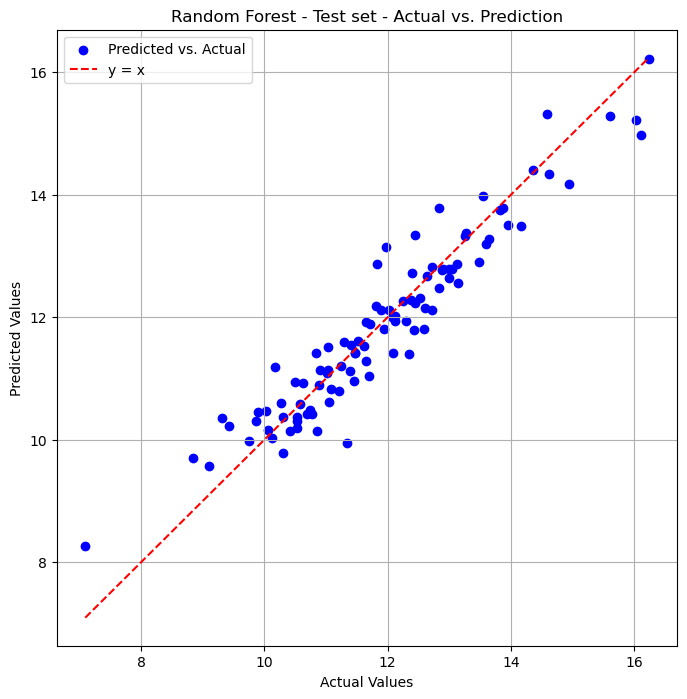

In [11]:
# Initialize the Random Forest model
model = RandomForestRegressor()

# Define grid search parameters
do_grid_search = False
grid_search_param = [{
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2]}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
RandFo_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess,
                             y_train=train_Y,
                             X_test=test_X_preprocess,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(RandFo_regressor)

plot_actual_vs_prediction(RandFo_regressor.y_test, RandFo_regressor.y_test_predicted, title='Random Forest - Test set - Actual vs. Prediction')

### Gradient Boosting regression model

Fitted model: GradientBoostingRegressor()

Full model parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Mean Squared Error: 0.1894516772391955

Mean Absolute Error: 0.33788866824027863

R² Score: 0.9270142300995345




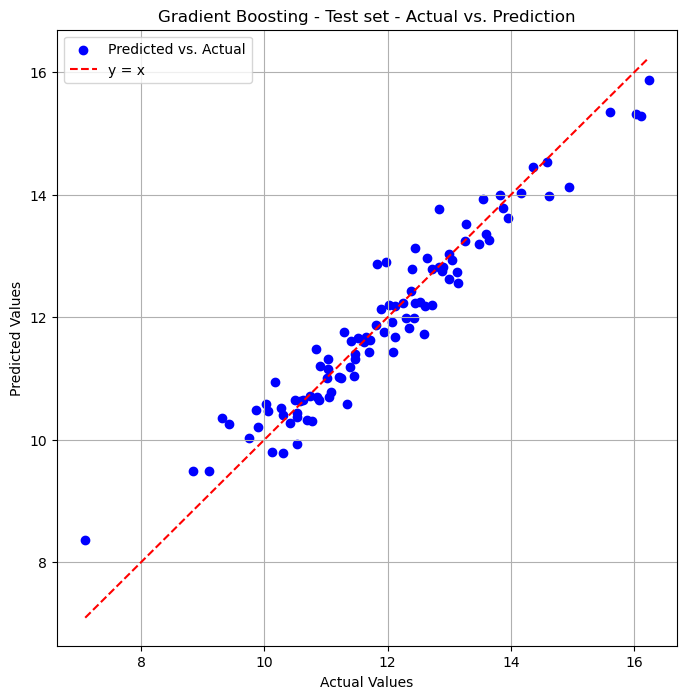

In [12]:
# Initialize the Random Forest model
model = GradientBoostingRegressor()

# Define grid search parameters
do_grid_search = False
grid_search_param = [{
    'n_estimators': [30],
    'learning_rate': [0.1],
    'max_depth': [5, 7],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [4, 8]}]
    #'subsample': [0.8, 0.9, 1.0]}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
GBoost_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess,
                             y_train=train_Y,
                             X_test=test_X_preprocess,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(GBoost_regressor)

plot_actual_vs_prediction(GBoost_regressor.y_test, GBoost_regressor.y_test_predicted, title='Gradient Boosting - Test set - Actual vs. Prediction')

### Performance evaluation on Validation set

Mean Squared Error: 8.825840329993762
Mean Absolute Error: 2.8987522843584044
R^2 Score: -5.496707388367115


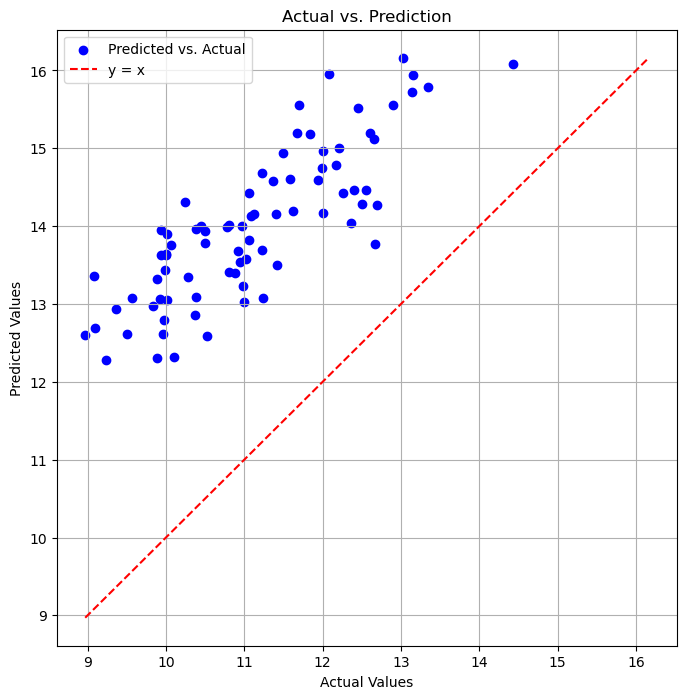

Mean Squared Error: 5.902670353164071
Mean Absolute Error: 2.208486819022367
R^2 Score: -3.344959874718655


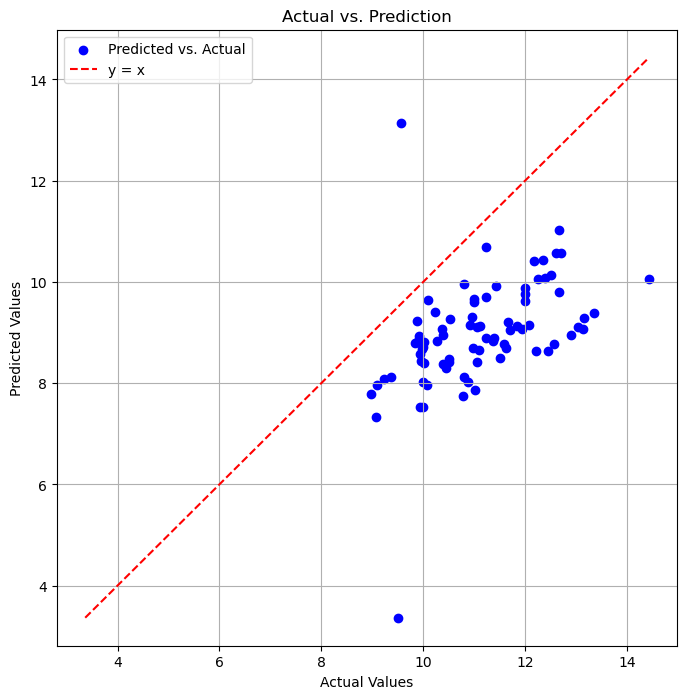

Mean Squared Error: 0.7119145423182154
Mean Absolute Error: 0.6215863292500002
R^2 Score: 0.47595919549475774


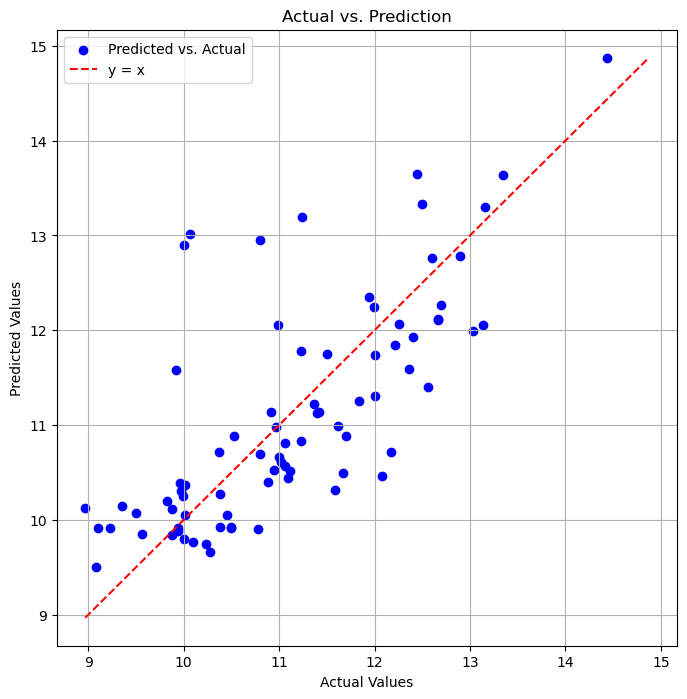

Mean Squared Error: 0.5982862731949444
Mean Absolute Error: 0.6436834574568693
R^2 Score: 0.5596010457820089


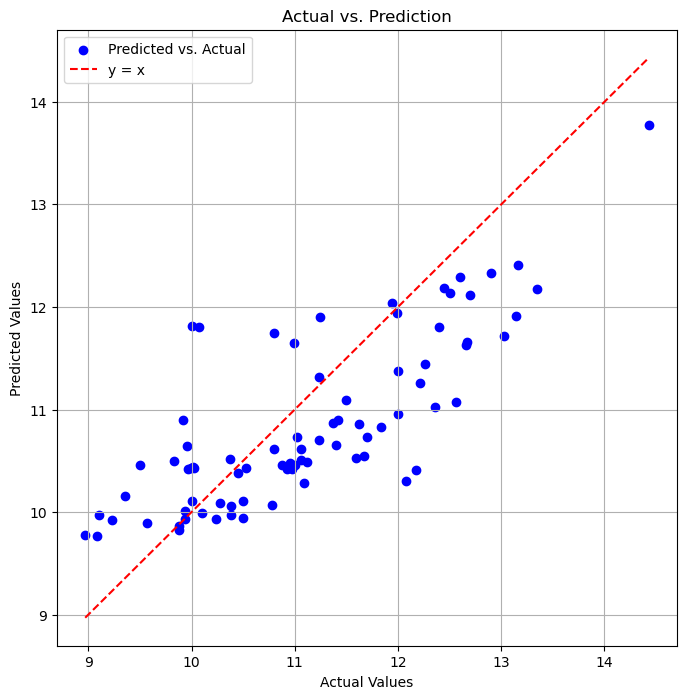

In [13]:
# Evaluate performance on validation set
models = [PLSqua_regressor, SVMach_regressor, RandFo_regressor, GBoost_regressor]

for model_to_eval in models:

    validation_Y_prd = model_to_eval.fitted_model.predict(validation_X_preprocess)

    mse = mean_squared_error(validation_Y_ref, validation_Y_prd)
    mae = mean_absolute_error(validation_Y_ref, validation_Y_prd)
    r2 = r2_score(validation_Y_ref, validation_Y_prd)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

    plot_actual_vs_prediction(validation_Y_ref, validation_Y_prd, title='Actual vs. Prediction')

#### Combining models predictions - Evaluation of performance

Mean Squared Error: 0.3769905838828815
Mean Absolute Error: 0.4704240136081202
R^2 Score: 0.7224969611864165


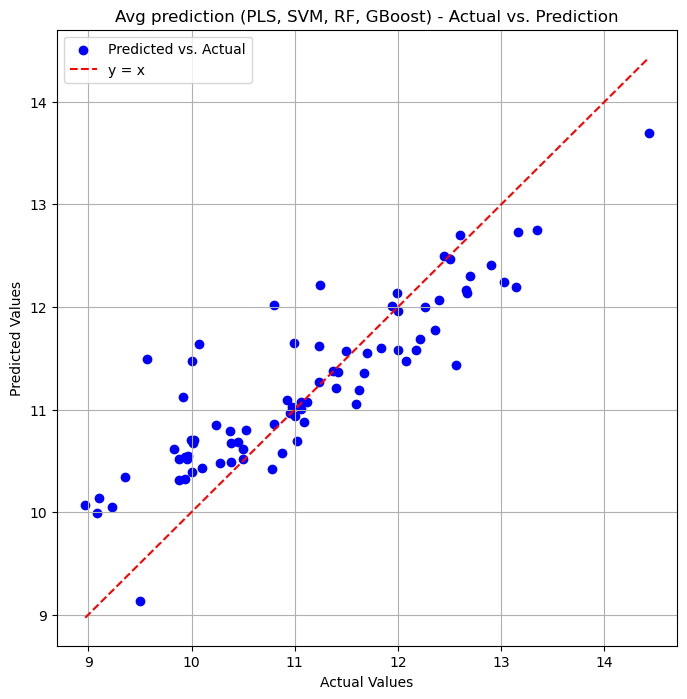

In [14]:
mean_prd_y = (PLSqua_regressor.fitted_model.predict(validation_X_preprocess)+
              SVMach_regressor.fitted_model.predict(validation_X_preprocess)+
              RandFo_regressor.fitted_model.predict(validation_X_preprocess)+
              GBoost_regressor.fitted_model.predict(validation_X_preprocess)) / 4

mse = mean_squared_error(validation_Y_ref, mean_prd_y)
mae = mean_absolute_error(validation_Y_ref, mean_prd_y)
r2 = r2_score(validation_Y_ref, mean_prd_y)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

plot_actual_vs_prediction(validation_Y_ref, mean_prd_y, title='Avg prediction (PLS, SVM, RF, GBoost) - Actual vs. Prediction')

### SVM regression model, based on PLS scores

In [15]:
train_X_preprocess_PLS_scores = PLSqua_regressor.fitted_model.transform(train_X_preprocess)
test_X_preprocess_PLS_scores = PLSqua_regressor.fitted_model.transform(test_X_preprocess)
validation_X_preprocess_PLS_scores = PLSqua_regressor.fitted_model.transform(validation_X_preprocess)

Fitted model: SVR()

Full model parameters: {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Mean Squared Error: 0.3192825512923646

Mean Absolute Error: 0.4376665229240503

R² Score: 0.8769972208140635




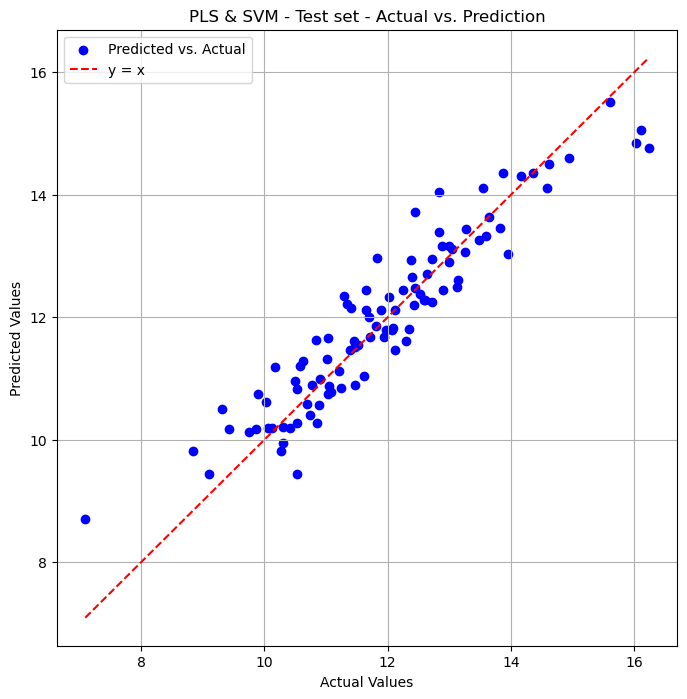

In [16]:
# Initialize the SVR model
model = SVR()

# Define grid search parameters
do_grid_search = False
grid_search_param = [{
    'C': [0.1, 1],
    'epsilon': [1, 0.1],
    'kernel': ['rbf', 'poly'],
    'degree': [4, 6],
    'gamma': ['auto', 'scale']}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
SVMach_PLS_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess_PLS_scores,
                             y_train=train_Y,
                             X_test=test_X_preprocess_PLS_scores,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(SVMach_PLS_regressor)

plot_actual_vs_prediction(SVMach_PLS_regressor.y_test, SVMach_PLS_regressor.y_test_predicted, title='PLS & SVM - Test set - Actual vs. Prediction')

### Random Forest regression, based on PLS scores

Fitted model: RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=75)

Full model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 75, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Mean Squared Error: 0.3245998546243435

Mean Absolute Error: 0.44100839550523113

R² Score: 0.8749487434232363




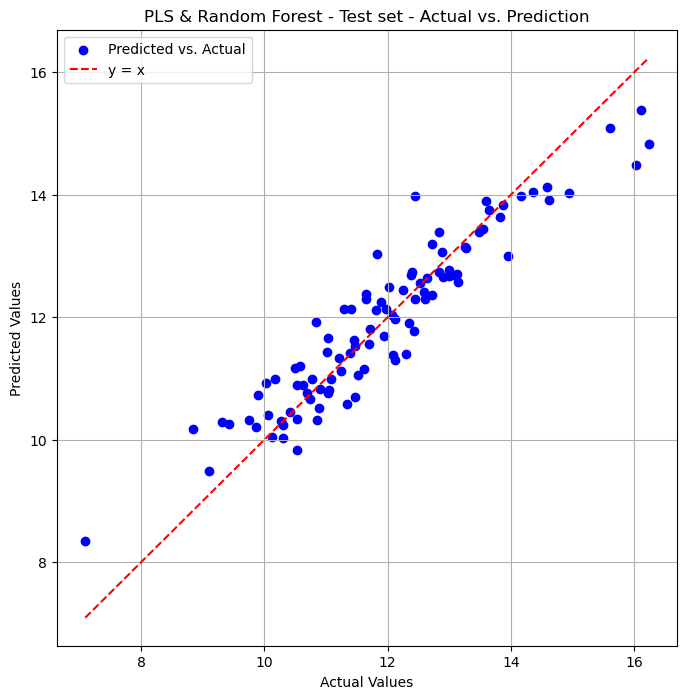

In [17]:
# Initialize the Random Forest model
model = RandomForestRegressor()

# Define grid search parameters
do_grid_search = True
grid_search_param = [{
    'n_estimators': [50, 75],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
RandFo_PLS_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess_PLS_scores,
                             y_train=train_Y,
                             X_test=test_X_preprocess_PLS_scores,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(RandFo_PLS_regressor)

plot_actual_vs_prediction(RandFo_PLS_regressor.y_test, RandFo_PLS_regressor.y_test_predicted, title='PLS & Random Forest - Test set - Actual vs. Prediction')

### Gradient Boosting regression model, based on PLS scores

Fitted model: GradientBoostingRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=20,
                          n_estimators=30)

Full model parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Mean Squared Error: 0.34043001190320504

Mean Absolute Error: 0.462603380854426

R² Score: 0.8688502161709046




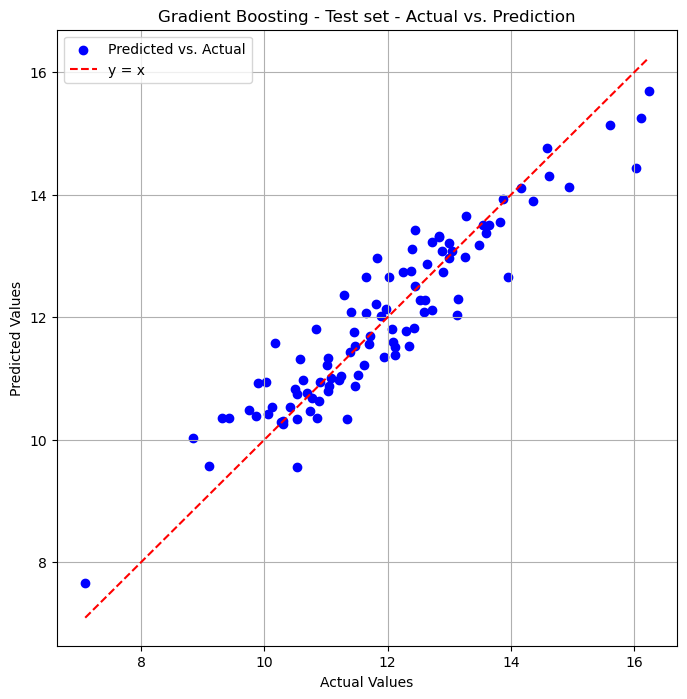

In [18]:
# Initialize the Random Forest model
model = GradientBoostingRegressor()

# Define grid search parameters
do_grid_search = True
grid_search_param = [{
    'n_estimators': [30],
    'learning_rate': [0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [20, 30, 40],
    'min_samples_leaf': [4, 8]}]
    #'subsample': [0.8, 0.9, 1.0]}]
grid_search_cv = 5
grid_search_scoring = 'neg_mean_squared_error'

# Initialize the Regressor object
GBoost_PLS_regressor = Regressor(model=model, 
                             X_train=train_X_preprocess_PLS_scores,
                             y_train=train_Y,
                             X_test=test_X_preprocess_PLS_scores,
                             y_test=test_Y,
                             do_grid_search=do_grid_search,
                             grid_search_param=grid_search_param,
                             grid_search_cv=grid_search_cv,
                             grid_search_scoring=grid_search_scoring)

# Print the regression model details and evaluation
print(GBoost_PLS_regressor)

plot_actual_vs_prediction(GBoost_PLS_regressor.y_test, GBoost_PLS_regressor.y_test_predicted, title='Gradient Boosting - Test set - Actual vs. Prediction')

### Performance evaluation on Validation set [models based on PLS scores]

Mean Squared Error: 3.3625759540379137
Mean Absolute Error: 1.5518203623165285
R^2 Score: -1.475194568193503


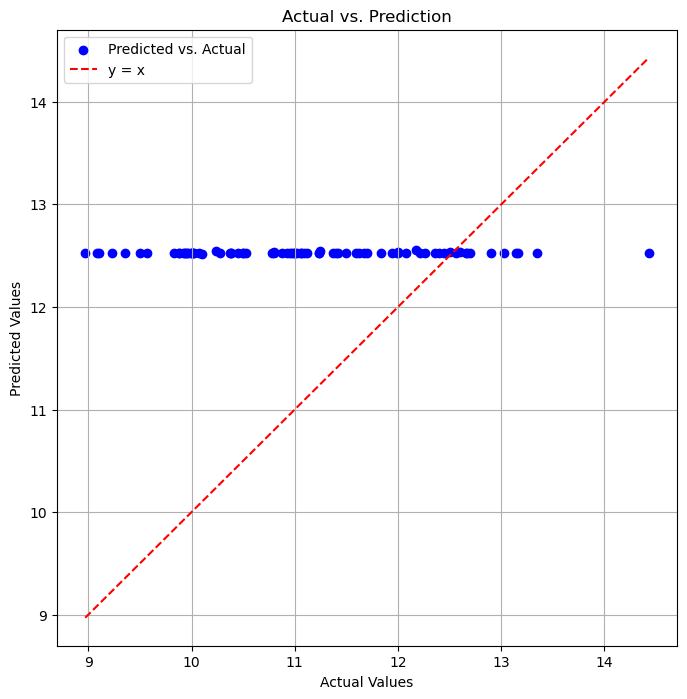

Mean Squared Error: 7.106251365155131
Mean Absolute Error: 2.42153475421668
R^2 Score: -4.230916719703434


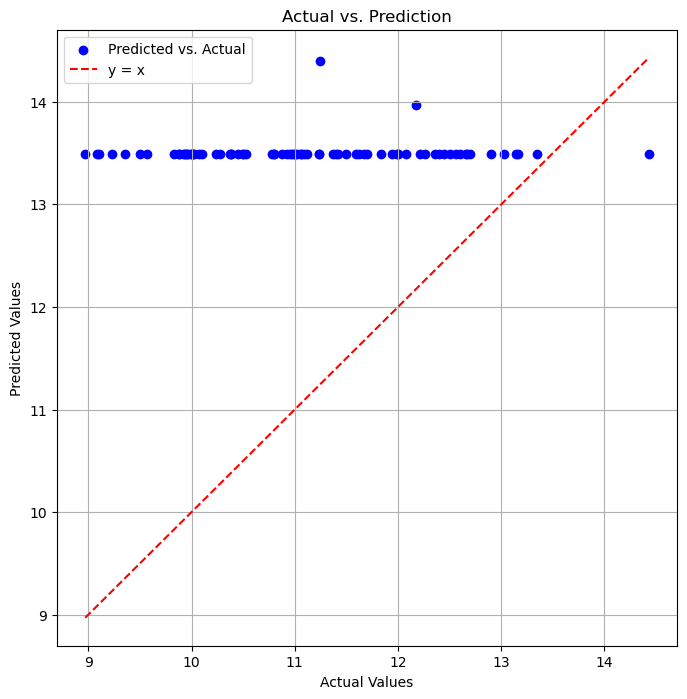

Mean Squared Error: 13.126834526343544
Mean Absolute Error: 3.4305253270744593
R^2 Score: -8.662672296863196


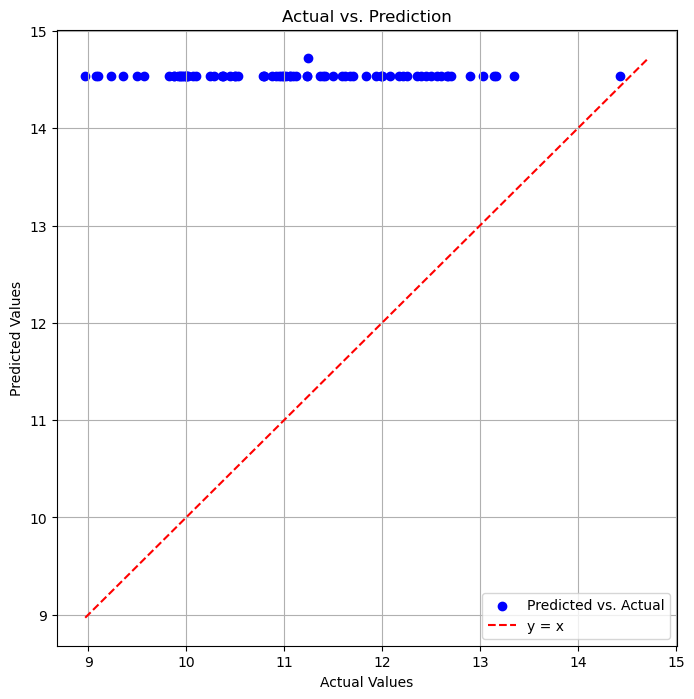

In [19]:
# Evaluate performance on validation set
models = [SVMach_PLS_regressor, RandFo_PLS_regressor, GBoost_PLS_regressor]

for model_to_eval in models:

    validation_Y_prd = model_to_eval.fitted_model.predict(validation_X_preprocess_PLS_scores)

    mse = mean_squared_error(validation_Y_ref, validation_Y_prd)
    mae = mean_absolute_error(validation_Y_ref, validation_Y_prd)
    r2 = r2_score(validation_Y_ref, validation_Y_prd)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

    plot_actual_vs_prediction(validation_Y_ref, validation_Y_prd, title='Actual vs. Prediction')